In [1]:
import pickle
data = pickle.load(open("data/data.plk", "rb"))

In [2]:
len(data)

4351

In [3]:
data[0]

{'abstrakt': '',
 'abstrakt (anglicky)': 'Salzella is a domain specific declarative language. Its primary focus lies in the field of music generation. The key principle upon which the language is built can be summarized as follows: For any existing piece of music it should be possible to create a Salzella program which will describe it in a way that running this program will output a piece of music similar to the original. Salzella programs are presumed to be generated rather then written by hand. The sole purpose of Salzella is to make creation of music generating tools easier. Bundling Salzella interpreter with music generating software and using it as an engine can provide a significant level of abstraction and thus make the development of such software a lot easier. Tools built on top of Salzella can generate Salzella programs and let the interpreter worry about the actual music generation. The key structural property of Salzella is extensibility. The algorithms responsible for the

In [38]:
import numpy as np
np.random.shuffle(data)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet


wordnet_lemmatizer = WordNetLemmatizer()

In [9]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
def get_lemmatized_words(sentence):
    _temp = []
    tokens = nltk.word_tokenize(sentence)
    
    for word, token in nltk.pos_tag(tokens):
        if word.strip().lower() not in stopwords.words('english') and word.strip().lower().isalpha() and len(word.strip().lower()) > 1:
            _temp.append(wordnet_lemmatizer.lemmatize(word.strip().lower(), get_wordnet_pos(token)))
    return _temp

In [41]:
import heapq
import operator
from collections import Counter
import numpy as np


def build_tf_idf_extractor(data,filter_predicate , keyword="abstrakt (anglicky)", ngram_range=(1,3)):
    data = [x for x in data if filter_predicate(x)]
    data_len = len(data)
    print("Number of documents:",data_len)
    
    if keyword != None:
    # CountVectorizer(): Convert a collection of text documents to a matrix of token counts
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram_range, lowercase=False,tokenizer=lambda key: get_lemmatized_words(data[key][keyword]))
    else:
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram_range, lowercase=False,tokenizer=lambda key: get_lemmatized_words(data[key]))
    
    # transform(raw_documents): Transform documents to document-term matrix
    cvec_counts = cvec.fit_transform(list(range(0,data_len)))
    
    # TfidfTransformer(): Transform a count matrix to a normalized tf or tf-idf representation
    transformer = TfidfTransformer()
    
    transformed_weights = transformer.fit_transform(cvec_counts)

    output = Counter()
    total_words_processed = 0
    for i in range(0, data_len):
        if i % 200 == 0:
            print (i)
        weights = transformed_weights.toarray()[i]
        five_keywords = heapq.nlargest(4, enumerate(weights), key=lambda x: x[1])
        keywords_str = []
        for keyword in five_keywords:
            total_words_processed+=1
            output[str(cvec.get_feature_names()[keyword[0]]).lower()] += 1
            keywords_str.append(str(cvec.get_feature_names()[keyword[0]]).lower())
                
    print("total keywords processed:", total_words_processed)
    return output, keywords_str

Number of documents: 20
0
total keywords processed: 80
Number of documents: 80
0
total keywords processed: 320


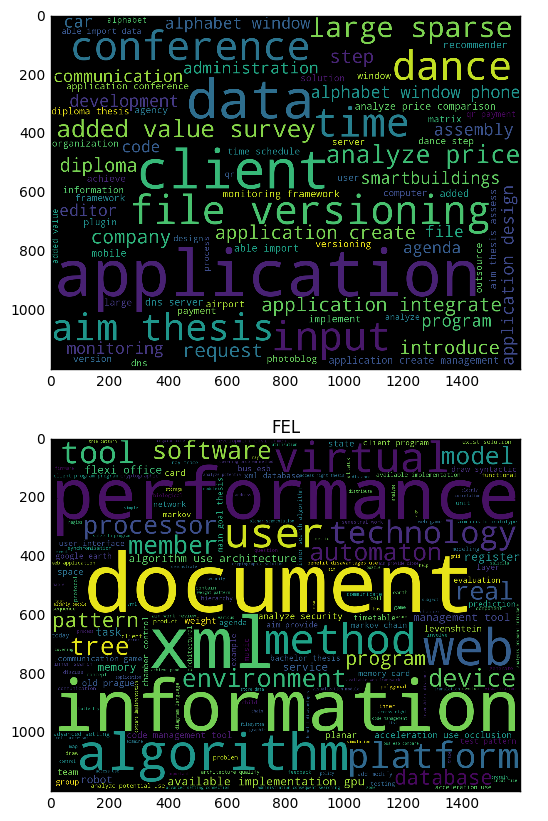

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


outputFit, keywordsFit = build_tf_idf_extractor(data[:100], filter_predicate=(lambda x: len(x["katedra"]) <= 4))
outputFel, keywordsFel = build_tf_idf_extractor(data[:100], filter_predicate=(lambda x: len(x["katedra"]) > 4))

wordcloudFit = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFit)
wordcloudFel = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFel)


plt.figure(1,figsize=(25,10))
plt.title("FIT")
plt.subplot(211)
plt.imshow(wordcloudFit, interpolation='bilinear')

plt.subplot(212)
plt.title("FEL")
plt.imshow(wordcloudFel, interpolation='bilinear')
plt.show()


Number of documents: 210
0
200
total keywords processed: 840
Number of documents: 790
0
200
400
600
total keywords processed: 3160


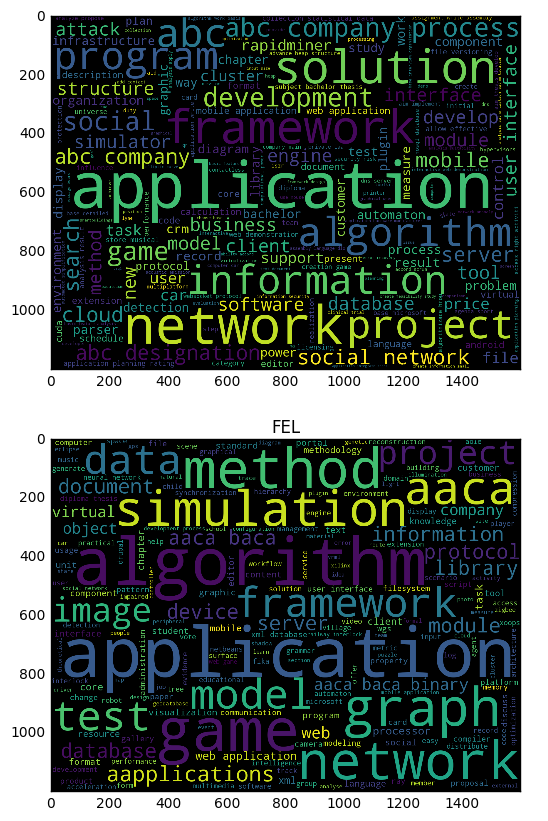

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


outputFit, keywordsFit = build_tf_idf_extractor(data[:1000], filter_predicate=(lambda x: len(x["katedra"]) <= 4))
outputFel, keywordsFel = build_tf_idf_extractor(data[:1000], filter_predicate=(lambda x: len(x["katedra"]) > 4))

wordcloudFit = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFit)
wordcloudFel = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFel)


plt.figure(1,figsize=(25,10))
plt.title("FIT")
plt.subplot(211)
plt.imshow(wordcloudFit, interpolation='bilinear')

plt.subplot(212)
plt.title("FEL")
plt.imshow(wordcloudFel, interpolation='bilinear')
plt.show()

In [36]:
def divide_to_two_groups(data, predicate_function, max_size=300, keyword="abstrakt (anglicky)"):
    
    if len(data) < max_size:
        raise AttributeError("Size of data is not sufficient to satisfy requested size")
    
    data_1 = []
    data_2 = []
    
    for item in data:
        if len(data_1) < max_size and predicate_function(item):
            data_1.append(item[keyword])
        elif len(data_2) < max_size:
            data_2.append(item[keyword])
        elif len(data_1) >= max_size and len(data_2) >= max_size:
            break
    
    if len(data_1) < max_size:
        print ("not full data_1, only:" ,len(data_1))
    if len(data_2) < max_size:
        print ("not full data_2, only:" , len(data_2))
    
    return data_1, data_2

Number of documents: 300
0
200
total keywords processed: 1200
Number of documents: 300
0
200
total keywords processed: 1200


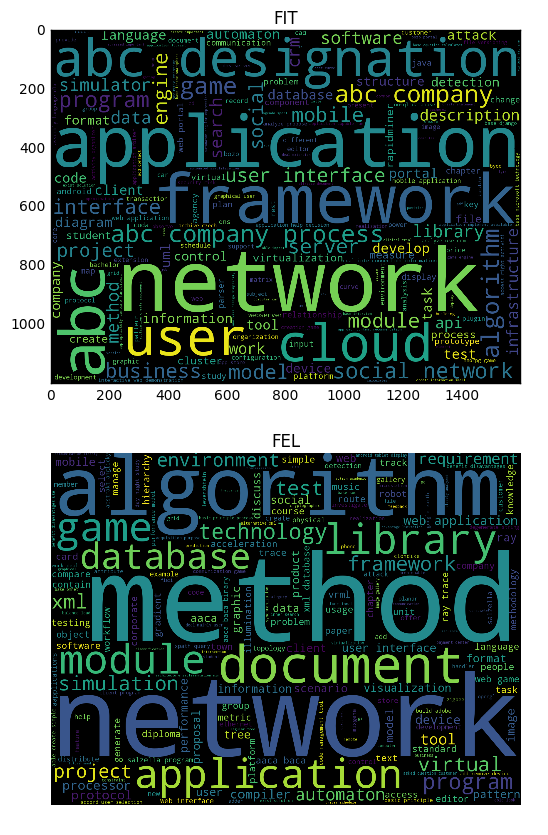

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_fit, data_fel = divide_to_two_groups(data, predicate_function=(lambda x: len(x["katedra"]) <= 4), max_size=300)

outputFit, keywordsFit = build_tf_idf_extractor(data_fit, filter_predicate=(lambda x: True), keyword=None)
outputFel, keywordsFel = build_tf_idf_extractor(data_fel, filter_predicate=(lambda x: True), keyword=None)

wordcloudFit = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFit)
wordcloudFel = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFel)


plt.figure(1,figsize=(25,10))
plt.subplot(211)
plt.title("FIT")
plt.imshow(wordcloudFit, interpolation='bilinear')

plt.subplot(212)
plt.title("FEL")
plt.imshow(wordcloudFel, interpolation='bilinear')
plt.axis("off")
plt.show()

Number of documents: 300
0
200
total keywords processed: 1200
Number of documents: 300
0
200
total keywords processed: 1200
According their English title


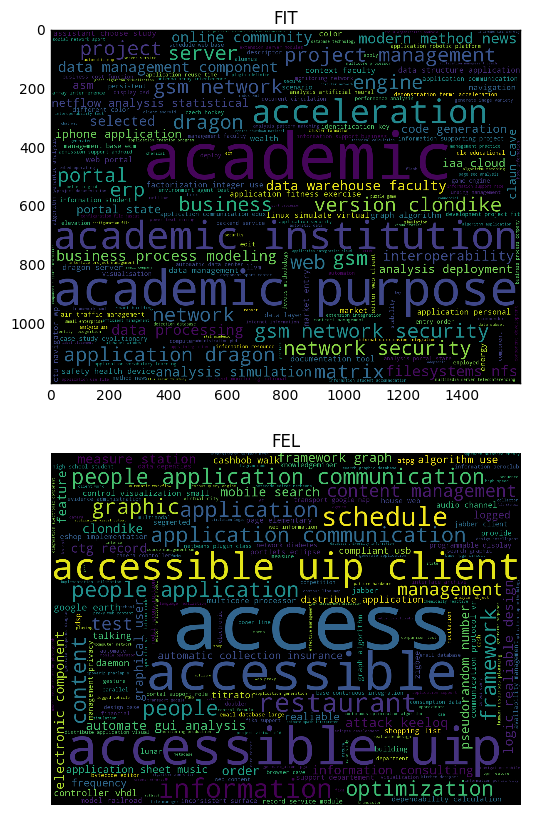

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_fit, data_fel = divide_to_two_groups(data, predicate_function=(lambda x: len(x["katedra"]) <= 4), max_size=300, keyword="název (anglicky)")

outputFit, keywordsFit = build_tf_idf_extractor(data_fit, filter_predicate=(lambda x: True), keyword=None)
outputFel, keywordsFel = build_tf_idf_extractor(data_fel, filter_predicate=(lambda x: True), keyword=None)

wordcloudFit = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFit)
wordcloudFel = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFel)

print ("According their English title")

plt.figure(1,figsize=(25,10))
plt.subplot(211)
plt.title("FIT")
plt.imshow(wordcloudFit, interpolation='bilinear')

plt.subplot(212)
plt.title("FEL")
plt.imshow(wordcloudFel, interpolation='bilinear')
plt.axis("off")
plt.show()

Number of documents: 300
0
200
total keywords processed: 1200
Number of documents: 300
0
200
total keywords processed: 1200
According their English title


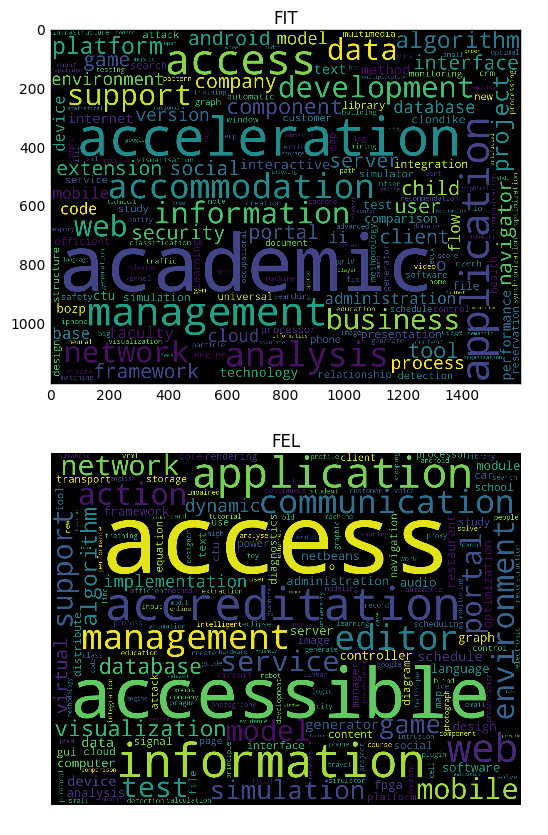

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_fit, data_fel = divide_to_two_groups(data, predicate_function=(lambda x: len(x["katedra"]) <= 4), max_size=300, keyword="název (anglicky)")

outputFit, keywordsFit = build_tf_idf_extractor(data_fit, filter_predicate=(lambda x: True), keyword=None, ngram_range=(1,1))
outputFel, keywordsFel = build_tf_idf_extractor(data_fel, filter_predicate=(lambda x: True), keyword=None, ngram_range=(1,1))

wordcloudFit = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFit)
wordcloudFel = WordCloud(width=1600,height=1200).generate_from_frequencies(outputFel)

print ("According their English title")

plt.figure(1,figsize=(25,10))
plt.subplot(211)
plt.title("FIT")
plt.imshow(wordcloudFit, interpolation='bilinear')

plt.subplot(212)
plt.title("FEL")
plt.imshow(wordcloudFel, interpolation='bilinear')
plt.axis("off")
plt.show()